In [1]:
# 导入库
import numpy as np  
import pandas as pd  
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.model_selection import GridSearchCV  
import matplotlib.pyplot as plt  

In [2]:
# 基本状态查看
def stats_summary(df):
    '''
    查看数据集的记录数、维度数、前2条数据、描述性统计和数据类型
    :param df: 数据框
    :return: 无
    '''
    print('Data Overview:')
    print('Records: {0}\tDimension：{1}'.format(df.shape[0], df.shape[1]))  # 打印数据形状
    print('-' * 30)
    print('The first two rows:')
    print(df.head(2))    # 输出前2条数据
    print('-' * 30)
    print('Data Desc:')
    print(df.describe())  # 输出数据描述性统计信息
    print('-' * 30)
    print('Data Dtypes:')
    print(df.dtypes)      # 输出数据类型
    print('-' * 30)


# 缺失值查看
def na_summary(df):
    '''
    查看数据集的缺失列、行数量
    :param df: 数据框
    :return: 无
    '''
    na_cols = df.isnull().any(axis=0)    # 判断每一列是否具有缺失值
    print('NA Cols:')
    print(na_cols)  
    print('-' * 30)
    print('Valid records for each cols:') # 查看每一列有效值（非NA）的记录数
    print(df.count())                  
    print('-' * 30)
    print('Total number of NA lines is: {0}'.format(df.isnull().any(axis=1).sum()))  # 查看具有缺失值的行的记录数
    print('-' * 30)

In [3]:
# 读取数据
raw_data = pd.read_table('products_sales.txt', delimiter=',')
 
# 数据审查和校验
# 数据概览
stats_summary(raw_data)
# 缺失值审查
na_summary(raw_data)

# 查看各列值域
col_names = ['limit_infor', 'campaign_type', 'campaign_level', 'product_level']  
for col_name in col_names:  
    unique_value = np.sort(raw_data[col_name].unique())  
    print('{1} unique values:{0}'.format(unique_value, col_name))  

Data Overview:
Records: 731	Dimension：11
------------------------------
The first two rows:
   limit_infor  campaign_type  campaign_level  product_level  resource_amount  \
0            0              6               0              1                1   
1            0              0               0              1                1   

   email_rate  price  discount_rate  hour_resouces  campaign_fee  orders  
0        0.08  140.0           0.83             93           888    1981  
1        0.10  144.0           0.75            150           836     986  
------------------------------
Data Desc:
       limit_infor  campaign_type  campaign_level  product_level  \
count   731.000000     731.000000      731.000000     731.000000   
mean      0.042408       2.997264        0.683995       1.395349   
std       0.404911       2.004787        0.465233       0.544894   
min       0.000000       0.000000        0.000000       1.000000   
25%       0.000000       1.000000        0.000000       1

In [4]:
# 相关性分析
print('Correlation Analyze:')
short_name = ['li', 'ct', 'cl', 'pl', 'ra', 'er', 'price', 'dr', 'hr', 'cf', 'orders']
long_name = raw_data.columns
name_dict = dict(zip(long_name, short_name))
# 输出所有输入特征变量以及预测变量的相关性矩阵
print(raw_data.corr().round(2).rename(index=name_dict, columns=name_dict))  
print(name_dict)

Correlation Analyze:
          li    ct    cl    pl    ra    er  price    dr    hr    cf  orders
li      1.00 -0.03 -0.08 -0.04  0.05  0.04  -0.02  0.00  0.01 -0.04   -0.02
ct     -0.03  1.00  0.04  0.03  0.01 -0.01  -0.05 -0.01  0.06  0.06    0.06
cl     -0.08  0.04  1.00  0.06  0.05  0.05   0.02  0.02 -0.52  0.26    0.05
pl     -0.04  0.03  0.06  1.00 -0.12 -0.12   0.59 -0.04 -0.25 -0.23   -0.30
ra      0.05  0.01  0.05 -0.12  1.00  0.98   0.13  0.15  0.54  0.46    0.62
er      0.04 -0.01  0.05 -0.12  0.98  1.00   0.14  0.18  0.54  0.47    0.63
price  -0.02 -0.05  0.02  0.59  0.13  0.14   1.00  0.25 -0.08 -0.11   -0.10
dr      0.00 -0.01  0.02 -0.04  0.15  0.18   0.25  1.00  0.17  0.19    0.23
hr      0.01  0.06 -0.52 -0.25  0.54  0.54  -0.08  0.17  1.00  0.32    0.66
cf     -0.04  0.06  0.26 -0.23  0.46  0.47  -0.11  0.19  0.32  1.00    0.76
orders -0.02  0.06  0.05 -0.30  0.62  0.63  -0.10  0.23  0.66  0.76    1.00
{'limit_infor': 'li', 'campaign_type': 'ct', 'campaign_level': 'cl'

In [5]:
# 数据预处理
sales_data = raw_data.fillna(raw_data['price'].mean())  # 缺失值替换为均值
sales_data = sales_data[sales_data['limit_infor'].isin((0, 1))]  # 只保留促销值为0和1的记录
sales_data['campaign_fee'] = sales_data['campaign_fee'].replace(33380, sales_data['campaign_fee'].mean())  # 将异常极大值替换为均值
sales_data = sales_data.drop('email_rate',axis=1) # 丢弃email_rate列

print('Transformed data:')
print(sales_data.describe().round(2).T.rename(index=name_dict))  # 打印处理完成数据基本描述性信息

Transformed data:
        count     mean      std     min      25%      50%      75%      max
li      730.0     0.03     0.17    0.00     0.00     0.00     0.00     1.00
ct      730.0     3.00     2.01    0.00     1.00     3.00     5.00     6.00
cl      730.0     0.68     0.47    0.00     0.00     1.00     1.00     1.00
pl      730.0     1.40     0.55    1.00     1.00     1.00     2.00     3.00
ra      730.0     4.95     1.84    1.00     3.00     5.00     7.00     9.00
price   730.0   162.82    14.26  100.00   152.00   163.00   173.00   197.00
dr      730.0     0.81     0.08    0.49     0.77     0.82     0.87     0.98
hr      730.0   848.51   687.03    2.00   315.25   717.00  1096.50  3410.00
cf      730.0  3655.61  1561.27   20.00  2495.00  3660.00  4783.25  6946.00
orders  730.0  4531.27  1933.85   22.00  3196.50  4566.00  6021.25  8714.00


In [6]:
# 分割数据集X和y
X = sales_data.iloc[:, :-1]  
y = sales_data.iloc[:, -1]  

# 模型最优化参数训练及检验
model_gbr = GradientBoostingRegressor()  # 建立GradientBoostingRegressor回归对象，不能容忍缺失值
parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate': [0.05, 0.1, 0.15],
              'max_depth': [2, 3, 4],
              'min_samples_split': [2, 3],
              'min_samples_leaf': [1, 2, 4]}  # 定义要优化的参数信息
model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5, n_jobs=-1)  # 建立交叉检验模型对象
model_gs.fit(X, y)  # 训练交叉检验模型
print('Best score is:', model_gs.best_score_)       # 获得交叉检验模型得出的最优得分
print('Best parameter is:', model_gs.best_params_)  # 获得交叉检验模型得出的最优参数

Best score is: 0.9312610228831086
Best parameter is: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


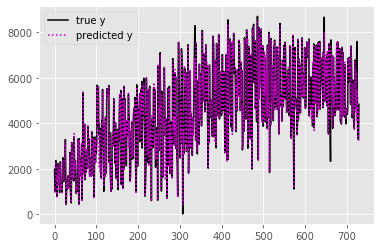

------------------------------
Predicted orders:
[767.]


C:\Users\Pr\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


In [7]:
# 获取最佳训练模型
model_best = model_gs.best_estimator_  # 获得交叉检验模型得出的最优模型对象
plt.style.use("ggplot")  # 应用ggplot自带样式库
plt.figure()             # 建立画布对象
plt.plot(np.arange(X.shape[0]), y, linestyle='-', color='k', label='true y')  # 画出原始变量的曲线
plt.plot(np.arange(X.shape[0]), model_best.predict(X), linestyle=':', color='m',label='predicted y')  # 画出预测变量曲线
plt.legend(loc=0)       # 设置图例位置
plt.show()              # 展示图像

# 新数据集预测
New_X = np.array([[1, 1, 0, 1, 15,  177, 0.66, 101, 798]])  # 要预测的新数据记录
print('-' * 30)
print('Predicted orders:')
print(model_best.predict(New_X).round(0))  # 打印输出预测值